<a href="https://colab.research.google.com/github/drewharris0103/Machine_Learning/blob/main/Bikes/fcc_bikes_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Data Set
 https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [212]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"] #"seasons", "holiday", ""
df = pd.read_csv("SeoulBikeData_fixed.csv").drop(["Date","Holiday","Seasons"], axis=1)

In [213]:
df.columns = dataset_cols
df["functional"] = (df["functional"]=="Yes").astype(int)
df = df[df["hour"] == 12]#.drop("hour")
df = df.drop("hour", axis=1)

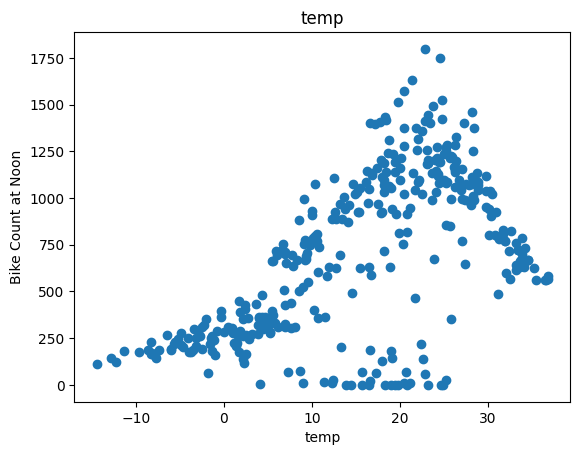

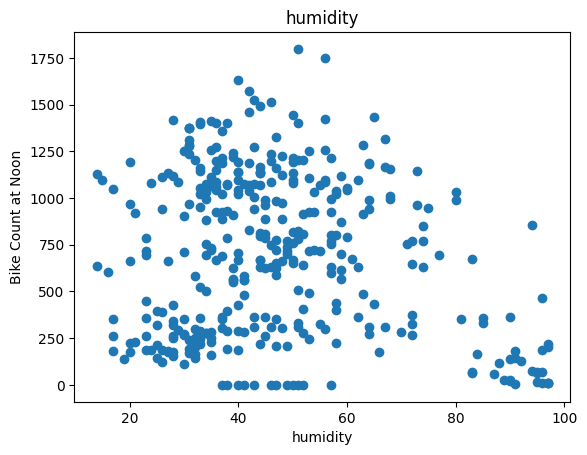

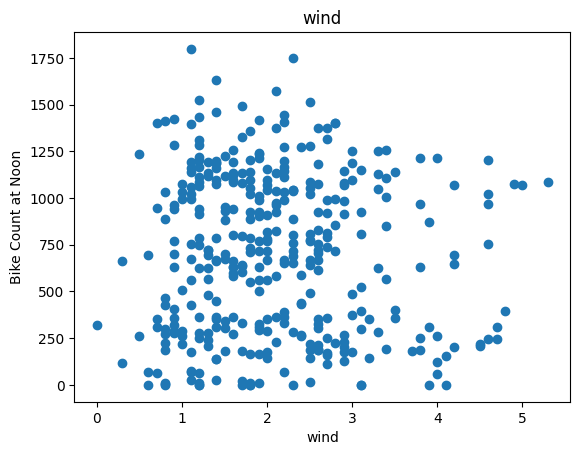

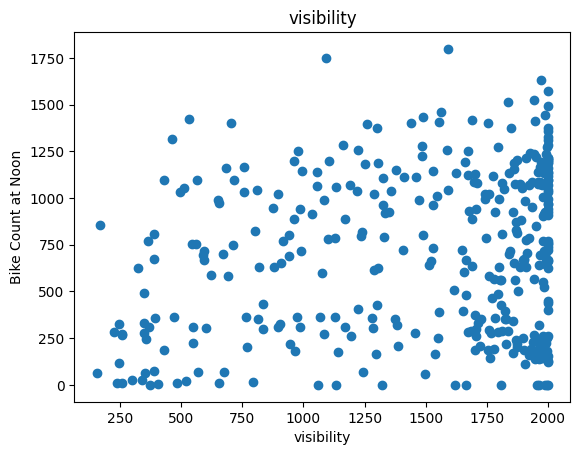

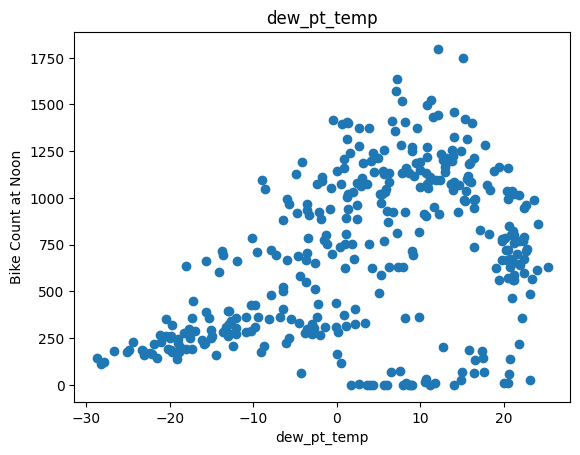

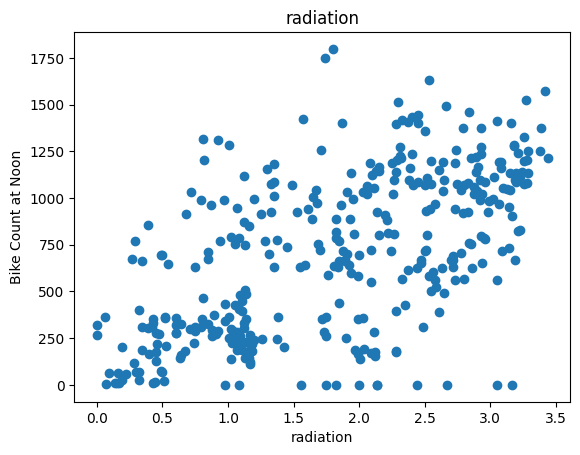

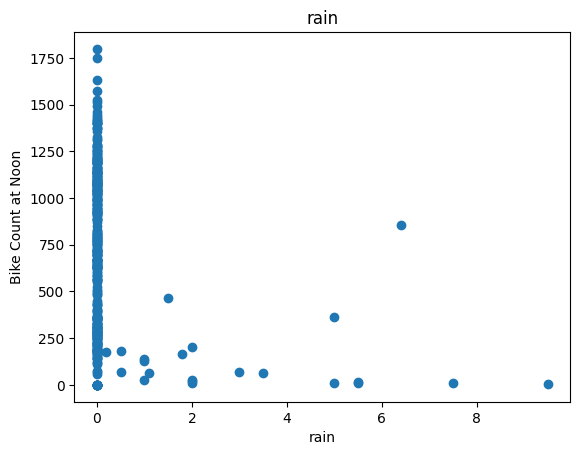

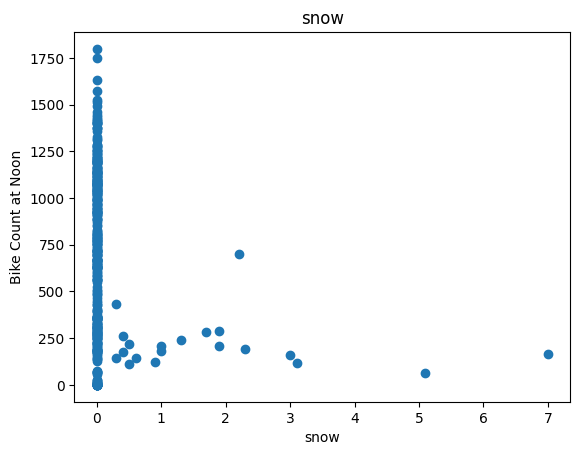

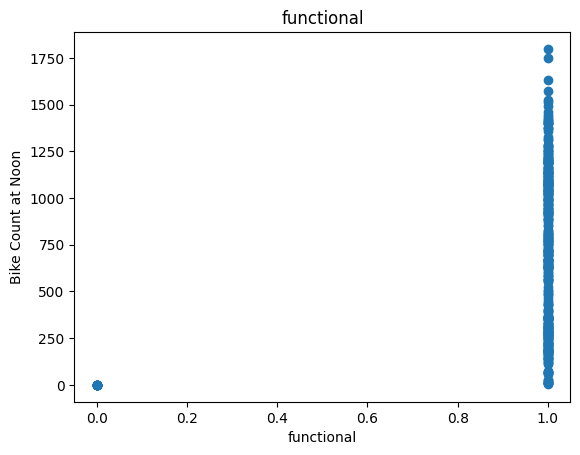

In [214]:
for label in df.columns[1:]: #everything after the first column
  plt.scatter(df[label],df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [215]:
df.drop(["wind", "visibility", "functional"], axis = 1)

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0
...,...,...,...,...,...,...,...
8652,752,9.1,57,1.0,1.69,0.0,0.0
8676,672,9.3,61,2.1,0.85,0.0,0.0
8700,635,7.9,14,-18.0,1.81,0.0,0.0
8724,661,5.6,27,-11.9,0.34,0.0,0.0


In [216]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


#Train/valid/test dataset

In [217]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

^^^ sampling data by mixing, frac = 1 means 100% of data being split, cut in groups of 0 - 60%, 60 - 80%, 80 - 100% (of the mixed data)

In [218]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c != y_label]].values
  else:
    if len(x_labels) == 1:
      x = dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1,1)
  data = np.hstack((x,y))

  return data, x, y

In [219]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count",x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count",x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count",x_labels=["temp"])


^^^^ splitting data sets (train, valid, test) into x and y dataframes: y values, x values

In [220]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp) #TRAINING MODEL

LinearRegression()

In [221]:
temp_reg.score(x_test_temp, y_test_temp) #closer to 1 is better

0.2529735032617244

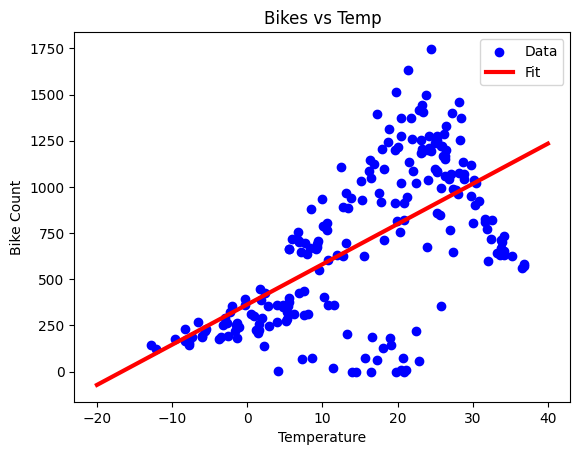

In [222]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bike Count")
plt.xlabel("Temperature")
plt.show()

#Multiple Linear Regression

In [223]:
_, x_train_all, y_train_all = get_xy(train, "bike_count")
_, x_val_all, y_val_all = get_xy(val, "bike_count")
_, x_test_all, y_test_all = get_xy(test, "bike_count")

In [224]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [225]:
all_reg.score(x_test_all, y_test_all)

0.5603957526570511

# Regression with Neural Net

In [232]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [227]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))


In [228]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [230]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [231]:
history = temp_nn_model.fit(
  x_train_temp.reshape(-1), y_train_temp.reshape(-1),
  verbose=0,
  epochs=1000,
  validation_data=(x_val_temp, y_val_temp),
)

In [234]:
history.history

{'loss': [666651.625,
  665302.375,
  663999.6875,
  662708.375,
  661348.375,
  660059.5625,
  658763.125,
  657459.0,
  656191.5,
  654901.4375,
  653576.25,
  652312.9375,
  651032.375,
  649775.0625,
  648492.125,
  647198.625,
  645940.375,
  644673.25,
  643409.5625,
  642148.8125,
  640901.5625,
  639599.9375,
  638360.3125,
  637116.625,
  635891.3125,
  634592.875,
  633360.25,
  632176.9375,
  630868.25,
  629645.0,
  628437.9375,
  627176.1875,
  625989.125,
  624740.5,
  623492.25,
  622261.75,
  621074.0625,
  619839.75,
  618657.8125,
  617442.3125,
  616225.75,
  615034.75,
  613795.4375,
  612633.4375,
  611412.375,
  610215.3125,
  609061.125,
  607840.3125,
  606669.0,
  605485.375,
  604307.125,
  603123.75,
  601965.9375,
  600765.8125,
  599592.625,
  598435.875,
  597245.9375,
  596117.5625,
  594951.625,
  593768.875,
  592605.125,
  591470.1875,
  590313.9375,
  589139.6875,
  588021.875,
  586830.25,
  585736.625,
  584582.1875,
  583460.0,
  582292.375,
  5811

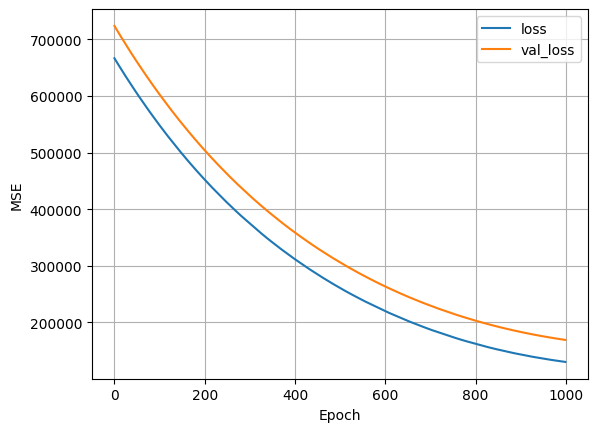

In [233]:
plot_loss(history)